# Time Series Techniques

- **Purpose:** Cover time series techniques for forecasting
- **Data:** Minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia. <a href="https://github.com/jbrownlee/Datasets" target="_blank">this link</a> 
- **Author:** Emily Diaz
- **Created on:** November 2nd of 2020 
- **Updated on:** November 10th of 2021 

References used to build this notebook: 
- https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python
- https://medium.com/@JoonSF/moving-to-tidy-forecasting-in-r-an-overview-of-exponential-smoothing-methods-43794c9e2b8

Took some of the functions used here from the kaggle one

## Time series

A time series is a sequence of observations measured at succesive times. Time series can come at different granularities such as monthly, trimestrial, weekly, daily, hourly and others.

Time series can be decomposed into four components, each expressing a particular aspect of the movement of the values of the time series:
- **Trend:** which describe the movement along the term
- **Seasonality:** which represent seasonal changes
- **Cycles:** which correspond to periodical but not seasonal variations
- **Variations:** which are other nonrandom sources of variations of series

<img src="img/time_series.jpg" />

We are going to cover the following techniques: 
- Simple Moving Average
- Exponential smoothing
- Holt Winters
- ARIMA 
- Linear regression
- XGBoost

This notebook is divided into the following sections/steps:
1. [Libraries](#libraries)
2. [Load data](#loaddata)
3. [Exploratory Data Analysis](#exploration)
4. [Data Preparation](#dataprep)
5. [Performance metrics](#performancemetrics)
6. [Time Series Analyses](#timeseries) <br>
    6.1 [TS - Moving Average](#movingaverage) <br>
    6.2 [TS - Exponential Smoothing](#exponentialsmoothing) <br>
    6.3 [TS - Holt-Winters](#holtwinters) <br>
    6.4 [TS - ARIMA](#arima) <br>
    6.5 [TS - Linear Regression](#linearregression) <br>
    6.6 [TS - XGB](#xgb) <br>

<a id="libraries"></a>
## 1. LIBRARIES

In [9]:
# General
import pandas as pd
import numpy as np
import datetime

# EDA and visualizations
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

#For regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# For XGB
from xgboost import XGBRegressor 

# For arima
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm  # for arima testing metrics/plot
import statsmodels.formula.api as smf  
import statsmodels.tsa.api as smt

# Modeling general
from sklearn.model_selection import TimeSeriesSplit # for validation sample when dealing with time series
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # performance metrics
from sklearn.metrics import mean_squared_log_error
from scipy.optimize import minimize

# Warnings/others
import warnings
warnings.filterwarnings('ignore') # to hide all warnings

### Functions

Several functions from sources to plot and calculate some of the models

MAPE

In [127]:
# MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


For Moving Average

In [128]:
# Moving average function from: https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(series[window:], label="Actual values")
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.legend(loc="upper left")
    plt.grid(True)

For exponential smoothing

In [129]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result



def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        plt.plot(series.values, "c", label = "Actual")
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
            plt.legend(loc="best")
            plt.axis('tight')
            plt.title("Exponential Smoothing")
            plt.grid(True);

For Holt Winters

In [130]:
# Holt-Winters
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [131]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [132]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    model_result = [x+0.01 for x in model.result]
    error = mean_absolute_percentage_error(train['Temp'].values[:len(model.result)] + 0.01,model_result) 
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.axvline(x= len(data), color = 'grey', label='split train/test', linestyle='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

For linear regression and XGB

In [133]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

For ARIMA

In [134]:
# Test of stationary, calculate ACF and PACF
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        acf_ax.set_xlabel('Lag')
        acf_ax.set_ylabel('ACF')
        pacf_ax.set_xlabel('Lag')
        pacf_ax.set_ylabel('PACF')

        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [135]:
%pwd

'/Users/natashadiaz/Documents/Personal - laptop/DS Sessions'

In [136]:
# Plot size
plt.rcParams['figure.figsize'] = [10, 6]

<a id="loaddata"></a>
## 2. LOAD DATA

In [3]:
df = pd.read_csv('./1_Input/daily-min-temperatures.txt', sep = ',')
print(df.shape)
df.head()

(3650, 2)


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


<a id="eda"></a>
## 3. EDA

In [4]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


<a id="dataprep"></a>
## 4. Data Prep

Date to right format

In [139]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].head()

0   1981-01-01
1   1981-01-02
2   1981-01-03
3   1981-01-04
4   1981-01-05
Name: Date, dtype: datetime64[ns]

As index

In [140]:
df = df.set_index('Date')

Useful calculations with time index

In [141]:
# Example of why is it useful to have the date as index 
df.resample('M').mean()

,Temp
Date,
1981-01-31,17.712903
1981-02-28,17.678571
1981-03-31,13.500000
1981-04-30,12.356667
1981-05-31,9.490323
...,...
1990-08-31,7.825806
1990-09-30,9.166667
1990-10-31,11.345161


In [142]:
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [189]:
# Rolling
df.rolling(7, min_periods=1).mean()

,Temp,day_year,year,month,day,day_of_year
Date,,,,,,
1981-01-01,20.700000,1.0,1981.0,1.0,1.0,1.0
1981-01-02,19.300000,1.5,1981.0,1.0,1.5,1.5
1981-01-03,19.133333,2.0,1981.0,1.0,2.0,2.0
1981-01-04,18.000000,2.5,1981.0,1.0,2.5,2.5
1981-01-05,17.560000,3.0,1981.0,1.0,3.0,3.0
...,...,...,...,...,...,...
1990-12-27,13.100000,358.0,1990.0,12.0,24.0,358.0
1990-12-28,13.171429,359.0,1990.0,12.0,25.0,359.0
1990-12-29,13.214286,360.0,1990.0,12.0,26.0,360.0


In [144]:
# Shift
df.shift(periods=3)

,Temp
Date,
1981-01-01,NaN
1981-01-02,NaN
1981-01-03,NaN
1981-01-04,20.7
1981-01-05,17.9
...,...
1990-12-27,10.0
1990-12-28,12.9
1990-12-29,14.6


### Visualizations

Text(0, 0.5, 'Temperature C')

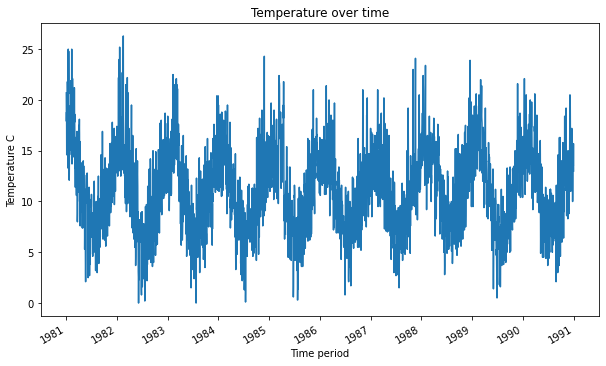

In [145]:
# Plot over time
df['Temp'].plot()
plt.title("Temperature over time")
plt.xlabel("Time period")
plt.ylabel("Temperature C")

In [191]:
# Compare first and last year to see changes
df["day_year"] = df.index.dayofyear
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day



fig = px.line(df[df["year"].isin([1981, 1990])], x='day_year', y='Temp', color='year',  
              title="Comparison of first and last year of the series",
              hover_data={'year':True,
                          'day_year':False,
                          'month':True,
                          'day':True
                            })
fig.update_layout(hovermode="x unified")
fig.show()


#### Series decomposition

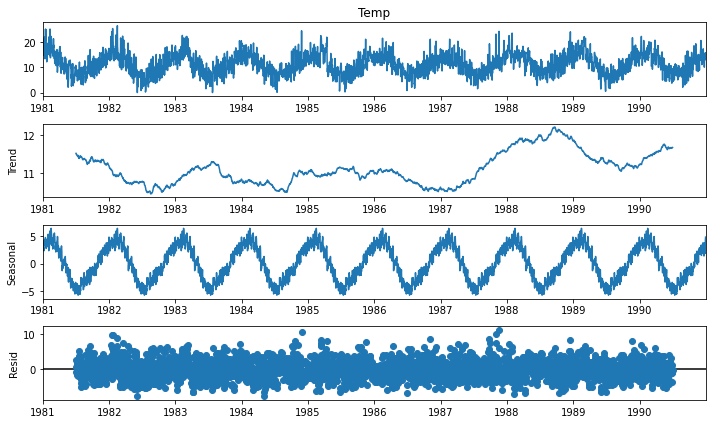

In [147]:
result = seasonal_decompose(df['Temp'], model='additive', period=365)
result.plot()
plt.show()

<a id="forecastmetrics"></a>
## 5. Forecast metrics

To measure the quality of the model and understand how much we can trust on futre forecasts, there are some metrics we are going to use:

**R squared:** coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model)
Range: (−∞,1] 

$$R2=1− \frac {SS_{res}}{SS_{tot}}$$   


**Mean Squared Error:** the most commonly used metric that gives a higher penalty to large errors and vice versa, 
Range: [0,+∞)

$$MSE = \frac {\sum_{i=1}^n {{(y_i - \hat y_i)^2}}} {n} $$


**Mean Absolute Percentage Error (MAPE):** this is calculated by obtaining the percentage of absolute error for each observation and then averaging to get the final value, which is very convenient when you want to explain the quality of the model to management
Range: [0,+∞)

$$MAPE = \frac {{\sum_{i=1}^n {\frac {\left\lvert y_i - \hat y_i \right\rvert} {y_i}}}}{n} * 100 $$



There are others as MAE, MedAE not covered on this notebook

<a id="timeseries"></a>
## 6. Time series analyses

Let's define a train and test set - Choosing based on date. Leaving one year to test
Here we don't randomly assigned data to train and test as each point is dependent of historical

In [148]:
# Leave one year for train
train = df[df.index <= '1989-12-31']
test = df[df.index > '1989-12-31']

print(train.shape)
print(test.shape)

(3285, 5)
(365, 5)


Useful link: https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37

<a id="movingaverage"></a>
### 6.1 Moving Average

Useful link: https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/

This techniques estimates future values by calculating the average of its  n  previous values. It's important to consider seasonality when choosing n. 

**Pros:**
- Requires less data than simple average
- Simple to calculate
- Easy to understand

**Cons:** 
- Needs at least k values before to be able to predict
- The larger the n is, more smoothing, the smaller the more sensitivity to outliers and over-reaction
- Lacks behind trend
- It cannot make predictions far in the future -- in order to get the value for the next step, needs the previous values to be actually observed.

In [149]:
train['Temp_MA_7'] = df['Temp'].rolling(window=7).mean()
train['Temp_MA_7'].head(10)


Date
1981-01-01          NaN
1981-01-02          NaN
1981-01-03          NaN
1981-01-04          NaN
1981-01-05          NaN
1981-01-06          NaN
1981-01-07    17.057143
1981-01-08    16.585714
1981-01-09    17.142857
1981-01-10    17.314286
Name: Temp_MA_7, dtype: float64

In [150]:
# train['Temp'].plot()
# train['Temp_MA_7'].plot(color='red')
# plt.show()

Overall plot

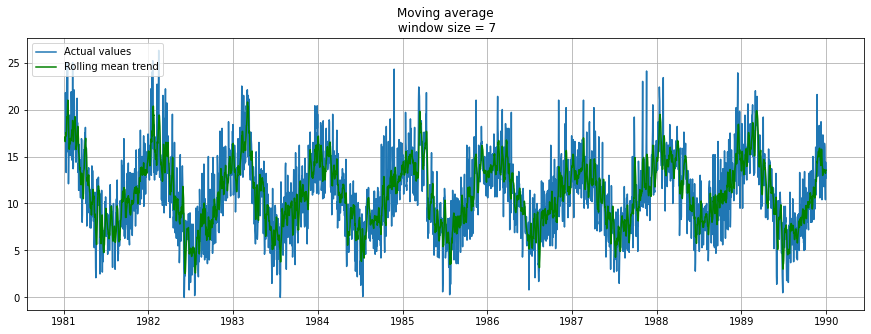

In [151]:
#plotMovingAverage(df['Temp'], 7) 
plotMovingAverage(train['Temp'], 7) 

With confidence intervals:

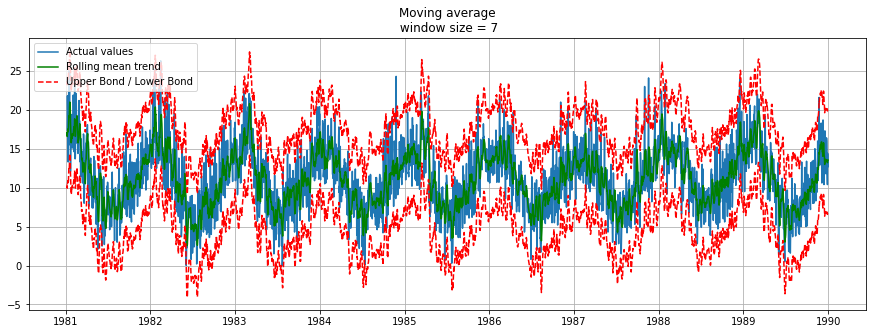

In [152]:
plotMovingAverage(train['Temp'], 7, plot_intervals=True)

Examplifying that if we increase the window, it gets smoother

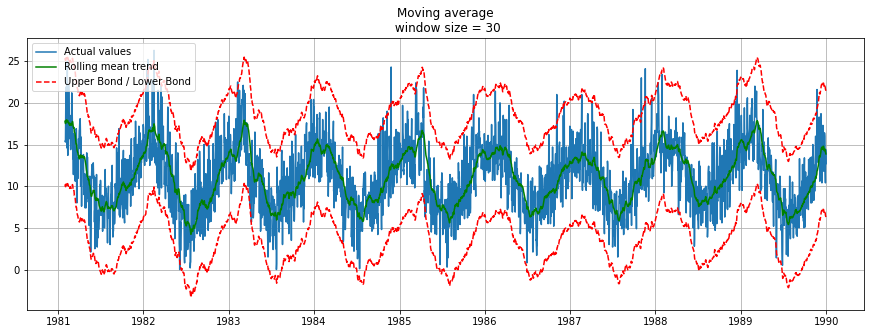

In [153]:
plotMovingAverage(train['Temp'], 30, plot_intervals=True)

#### Performance metrics

In [154]:
# R2 fit: Only will work with the window of values (7 of them) 
print('R2: ' + str(r2_score(train['Temp'][7:], train['Temp_MA_7'][7:])))

# MAPE
print('MAPE: ' + str(mean_absolute_percentage_error(train['Temp'][7:] + 0.01, train['Temp_MA_7'][7:] + 0.01)))# 12%

R2: 0.6499798032510555
MAPE: 56.98261732516221


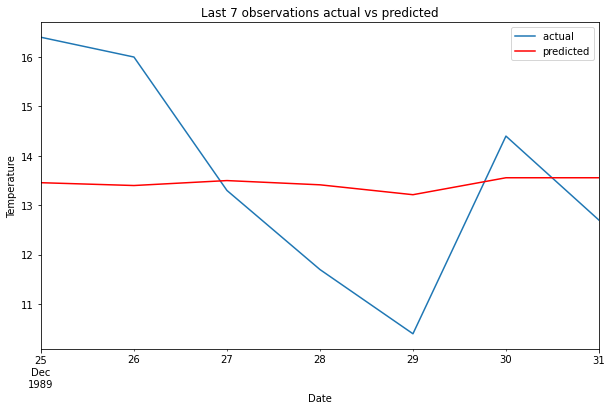

In [155]:
# Plot of just the 7 last observations of train set
train['Temp'][-7:].plot(label="actual ")
train['Temp_MA_7'][-7:].plot(color='red', label="predicted")
plt.title("Last 7 observations actual vs predicted")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()

This is not an algorithm with memory or that we are saving to use later, therefore we didn't use test set to see accuracy. How it could be used is, every time that there is new data, calculate average as we did here

<a id="exponentialsmoothing"></a>
### 6.2 Exponential smoothing

Useful link: https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

Exponential Smoothing (ES) creates predictions as a weighted sum of past observations, but the model explicitly uses an exponentially decreasing weight for past observations, meaning that the older the data, the less weight it gets. It has a parameter **α**  which is a weight called a **smoothing factor**. It defines how quickly we will "forget" the last available true observation.

Alpha is often set to a value between 0 and 1. Large values mean that the model pays attention mainly to the most recent past observations, whereas smaller values mean more of the history is taken into account when making a prediction.

**Pros:** 
 - Easy to compute
 - It gives more importance to recent observations
 
**Cons:**
- It cannot handle trends well
- Cannot be used for series with a cyclical nature
- Ignores random variation in favor of a smoothing process

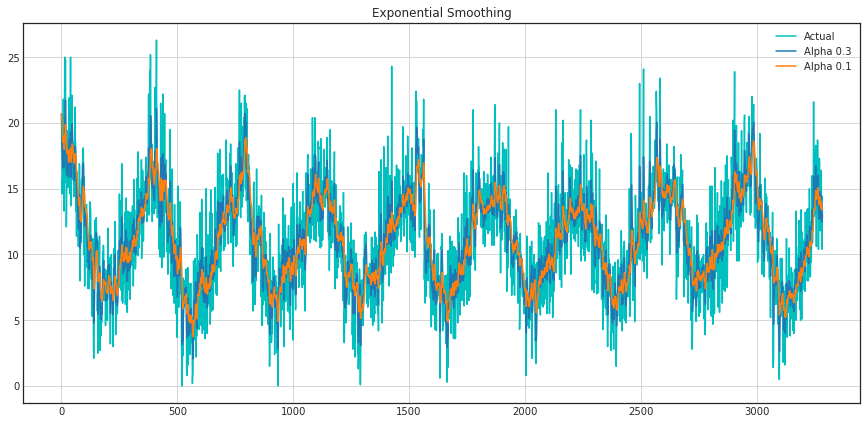

In [156]:
plotExponentialSmoothing(train['Temp'], [0.3, 0.1])

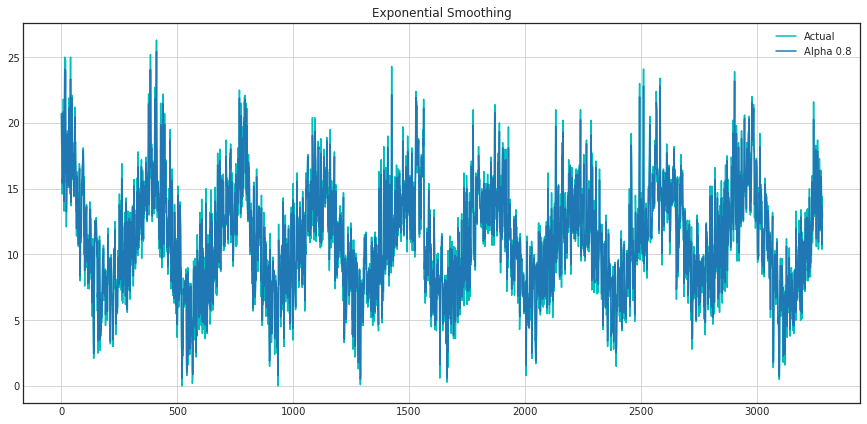

In [157]:
plotExponentialSmoothing(train['Temp'], [0.8])

### Accuracy performance

For Alpha 0.3

In [158]:
# Calculate values
pred = exponential_smoothing(train['Temp'], 0.3)
pred = [x+0.01 for x in pred]

# MAPE
print('MAPE: ' + str(mean_absolute_percentage_error((train['Temp'] + 0.01), pred)))

# R2
print('R2: ' + str(r2_score(train['Temp'] + 0.01, pred)))


MAPE: 43.64648376765151
R2: 0.796816454480666


For Alpha 0.8

In [159]:
# Calculate values
pred = exponential_smoothing(train['Temp'], 0.8) # Function defined at the beginning of the notebook
pred = [x+0.01 for x in pred]

# MAPE
print('MAPE: ' + str(mean_absolute_percentage_error((train['Temp'] + 0.01), pred)))

# R2
print('R2: ' + str(r2_score(train['Temp'] + 0.01, pred)))


MAPE: 10.664958101392271
R2: 0.9829503667730988


This is not an algorithm with memory or that we are saving to use later, therefore we didn't use test set to see accuracy. How it could be used is, every time that there is new data, calculate average as we did here

<a id="holtwinters"></a>
### 6.3 Holt-Winters

This is a type of exponential smoothing model where it is applied exponential smoothing three times. The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations:
- one for the level **ℓ**
- one for the trend **b**
- one for the seasonal component **s**

We should not use this method if our time series is not expected to have seasonality.

With corresponding smoothing parameters  α,  β and  γ. We use m to denote the frequency of the seasonality, i.e., the number of seasons in a year. For example, for quarterly data m = 4, and for monthly data m = 12.

There are 2 types: 
1. Additive:
    - Additive method adds or subtracts seasonality
    - The seasonal component is expressed in absolute terms and averages to 0
    - Best when the seasonal variations are mostly constant through the series
2. Multiplicative
    - Multiplicative method multiplies or divides seasonality
    - The seasonal component is expressed in relative percentage terms and averages to 1
    - Best when the seasonal variations are changing with the level of the series
    
  We are going to use additive:

In [160]:
# Data for training
data = train[train.index<= '1985-12-31']['Temp'] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, # TimeseriesCVscore is a function at the beggining of this notebook
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 365, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = len(train)-len(data), scaling_factor = 3)
model.triple_exponential_smoothing()

0.004726381967164794 0.0 0.005054911520844696


In [161]:
len(train)-len(data)

1460

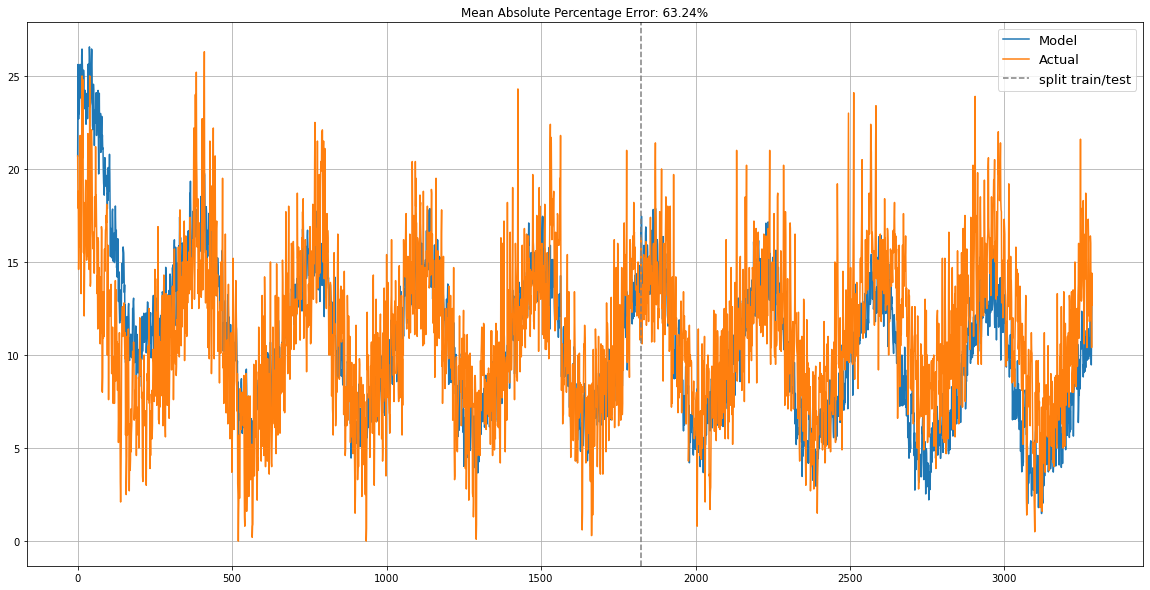

In [162]:
plotHoltWinters(train['Temp'])

#### Performance

In [163]:
# Calculate values
pred = model.result
pred = [x+0.01 for x in pred]

# MAPE
print('MAPE: ' + str(mean_absolute_percentage_error((train['Temp'] + 0.01), pred)))

# R2
print('R2: ' + str(r2_score(train['Temp'] + 0.01, pred)))


MAPE: 63.242285278516974
R2: 0.2755057087683601


<a id="arima"></a>
### 6.4 ARIMA 

Useful links:
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://otexts.com/fpp2/arima.html
- https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

ARIMA stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration. ARIMA models aim to describe the autocorrelations in the data.

- **Autoregression(AR):** A model that uses the dependent relationship between an observation and some number of lagged observations. This is the regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as p. To determine the initial  p , you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.
- **Integrated (I):** The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary
- **Moving Average (MA)** A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. This component models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as  q . The initial value can be found on the ACF plot with the same logic as p.

**What is stationary?** 
A stationary time series is one whose properties do not depend on the time at which the series is observed.  The mean is realtively constant and the variance is pretty much stable. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance. Look for more information and examples here: https://otexts.com/fpp2/stationarity.html

<img src="img/stationary.png" />

**So why is stationarity so important?** Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). 

**The parameters of the ARIMA model are defined as follows:**

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.


Step 1: Determine stationary behavior

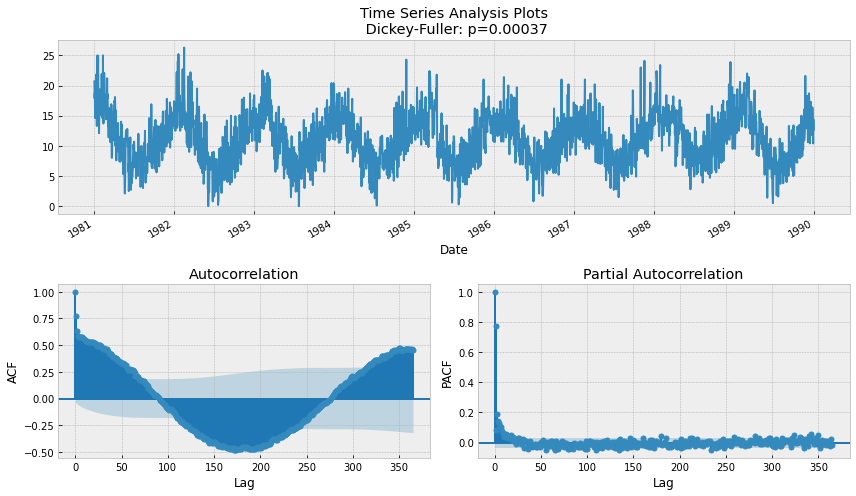

In [164]:
tsplot(train['Temp'], lags=365)

**Dickey-Fuller test** resulted in rejecting the null hypothesis that a unit root is present in an autoregressive model (p-value). Therefore, the series is non-stationary

**Autocorrelation plot:** Designed to show whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. It can range from –1 to 1 (y axis), if autocorrelation values are close to 0, then values between consecutive observations are not correlated with one another. Inversely, autocorrelations values close to 1 or -1 indicate that there exists strong positive or negative correlations between consecutive observations, respectively. X axis represent the lags. Each spike that rises above or falls below the shaded area is considered to be statistically significant. 

Ideally, we want the test null hypothesis to be rejected and the autocorrelations to be low (this can be modified/improve by removing seasonality)

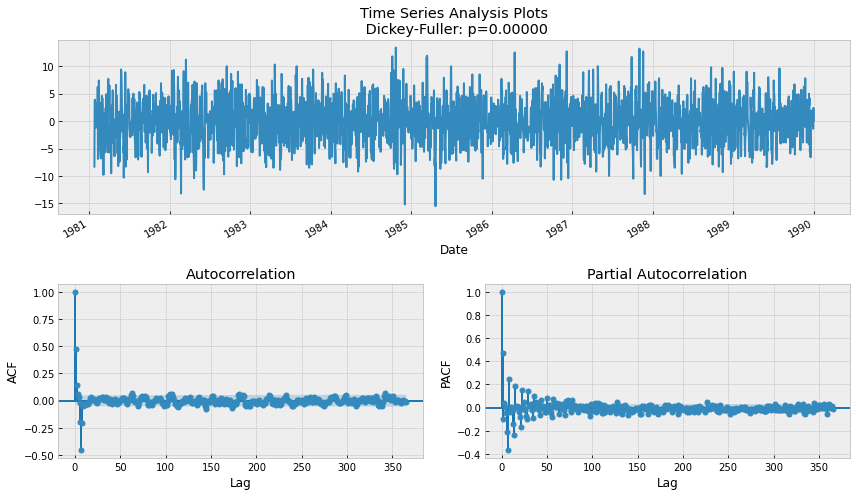

In [165]:
# Results from doing the same but substracting the seasonality of "7 days"
temp_diff = train['Temp'] - train['Temp'].shift(7)
tsplot(temp_diff[24:], lags=365)

To define a good start of the parameters we can use the following functions:

In [166]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score)) 

In [167]:
# evaluate_models(train['Temp'], p_values = [1, 7], d_values = [0,1], q_values = [1, 7]) 
# # get the combination with lower MSE

Inside function there is a train/testing

Fit final model

In [168]:
# Fit model

model = ARIMA(train['Temp'], order=(1,0,7)) # takes a while if we increase numbers
#The (p,d,q) order of the model for the autoregressive, differences, and moving average components. 
# d is always an integer, while p and q may either be integers or lists of integers.
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                   Temp   No. Observations:                 3285
Model:                     ARMA(1, 7)   Log Likelihood               -7565.628
Method:                       css-mle   S.D. of innovations              2.420
Date:                Fri, 12 Nov 2021   AIC                          15151.257
Time:                        11:37:13   BIC                          15212.228
Sample:                             0   HQIC                         15173.087
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4325      0.888     12.878      0.000       9.693      13.172
ar.L1.Temp     0.9922      0.003    387.523      0.000       0.987       0.997
ma.L1.Temp    -0.4016      0.018    -22.762      0.0

Text(0, 0.5, 'Temperature')

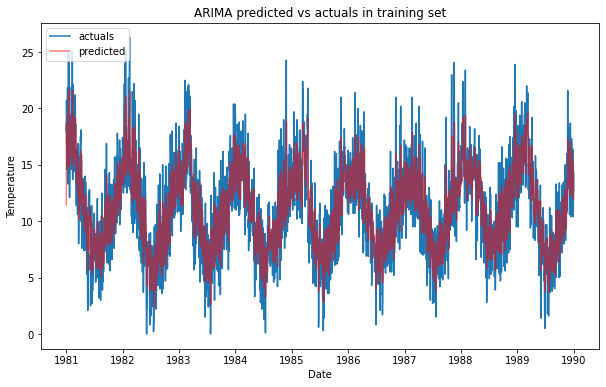

In [169]:
# Results vs model
results = model.fit(disp=-1)
plt.plot(train['Temp'], label = 'actuals')
plt.plot(model_fit.fittedvalues, color='red', label = 'predicted', alpha=0.5)
plt.legend(loc="upper left")
plt.title("ARIMA predicted vs actuals in training set")
plt.xlabel("Date")
plt.ylabel("Temperature")

In [170]:
# # Plot residual errors
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()
# residuals.plot(kind='kde')
# plt.show()
# print(residuals.describe())

In [171]:
# # Forecast all years
# results.plot_predict(1,3650)


In [172]:
# def plotSARIMA(series, model, n_steps, s, d):
#     """
#         Plots model vs predicted values
        
#         series - dataset with timeseries
#         model - fitted SARIMA model
#         n_steps - number of steps to predict in the future
        
#     """
#     # adding model values
#     data = series.copy()
#     data.columns = ['actual']
#     data['arima_model'] = model.fittedvalues
#     # making a shift on s+d steps, because these values were unobserved by the model
#     # due to the differentiating
#     data['arima_model'][:s+d] = np.NaN
    
#     # forecasting on n_steps forward 
#     forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
#     forecast = data.arima_model.append(forecast)
#     # calculate error, again having shifted on s+d steps from the beginning
#     error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

#     plt.figure(figsize=(15, 7))
#     plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
#     plt.plot(forecast, color='r', label="model")
#     plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
#     plt.plot(data.actual, label="actual")
#     plt.legend()
#     plt.grid(True);
    
    
# plotSARIMA(df.Temp, model_fit,50, s = 365, d = 1)

Some things missing for this example are: Checking prediction in testing and calculating MAPE

<a id="linearregression"></a>
### 6.5 LINEAR REGRESSION

For the following 2, we can create more variables to help us predict the time series. Let's crete lags

In [173]:
# Extract year
df['year'] = df.index.year
df['Date'] = df.index
df['day_of_year'] = df.Date.dt.dayofyear
# Dataframe for analysis
df_multivar = df[['Temp', 'year', 'day_of_year']]
df_multivar.head()


,Temp,year,day_of_year
Date,,,
1981-01-01,20.7,1981,1
1981-01-02,17.9,1981,2
1981-01-03,18.8,1981,3
1981-01-04,14.6,1981,4
1981-01-05,15.8,1981,5


Creating lags

In [174]:
# Lags for week, bi-week, month, quarter, semester and year
periods_lag = [7, 15, 30, 90, 180, 365]
for i in periods_lag:
    df_multivar["lag_{}".format(i)] = df_multivar.Temp.shift(i)

df_multivar.head(20)

,Temp,year,day_of_year,lag_7,lag_15,lag_30,lag_90,lag_180,lag_365
Date,,,,,,,,,
1981-01-01,20.7,1981,1,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-02,17.9,1981,2,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-03,18.8,1981,3,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-04,14.6,1981,4,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-05,15.8,1981,5,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-06,15.8,1981,6,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-07,15.8,1981,7,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-08,17.4,1981,8,20.7,NaN,NaN,NaN,NaN,NaN
1981-01-09,21.8,1981,9,17.9,NaN,NaN,NaN,NaN,NaN


In [175]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

Create train and test dataset

In [176]:
y = df_multivar.dropna().Temp
X = df_multivar.dropna().drop(['Temp'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

In [177]:
# Model 
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [178]:
def plotModelResults(model, X_train=X_train, X_test=X_test, y_test= y_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Test dataset prediction vs actuales, Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.title("Coefficients of liner regression")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [179]:
lr.coef_ , X_train.columns

(array([ 0.11328795, -0.00108135,  0.23628445,  0.16213943,  0.14736836,
        -0.08497803, -0.11463455,  0.18668729]),
 Index(['year', 'day_of_year', 'lag_7', 'lag_15', 'lag_30', 'lag_90', 'lag_180',
        'lag_365'],
       dtype='object'))

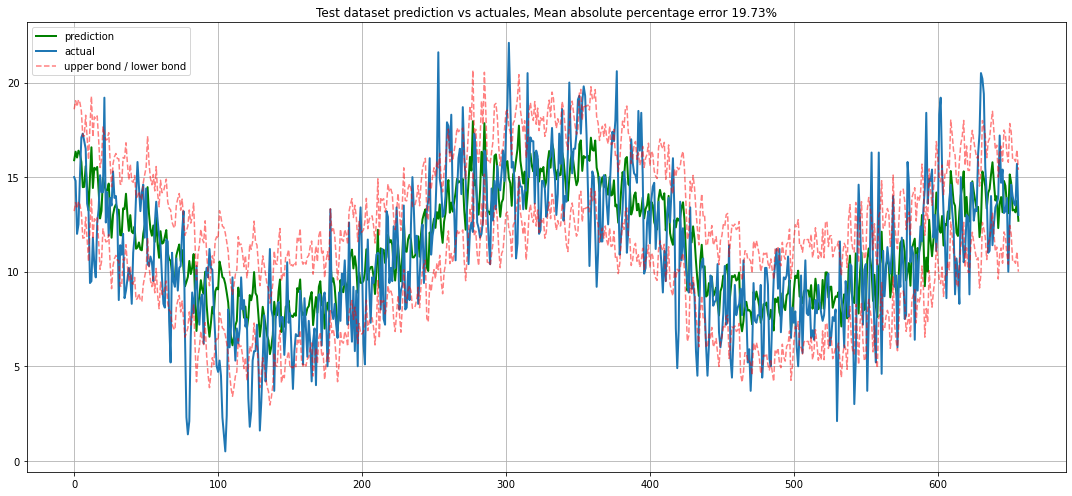

In [180]:
plotModelResults(lr, plot_intervals=True)


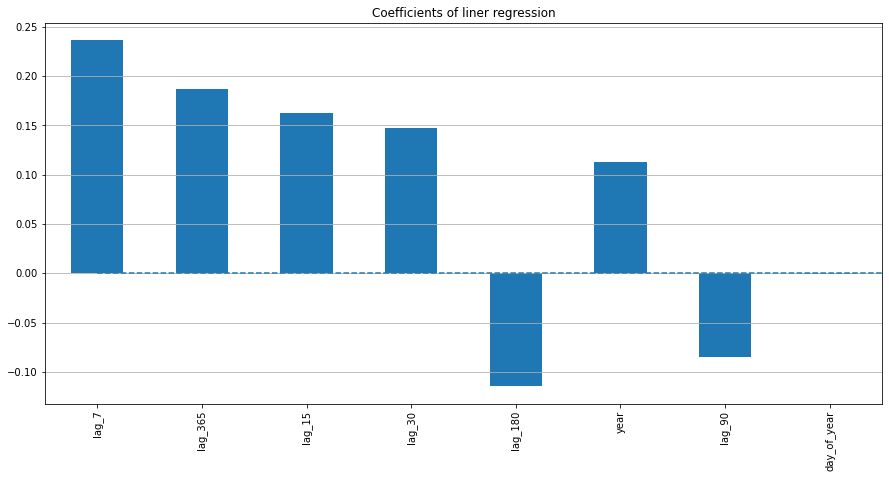

In [181]:
plotCoefficients(lr)


In [182]:
# MAPE AND R2
y_pred_lr = lr.predict(X_test)

print('Train MAPE: ' + str(mean_absolute_percentage_error(y_train+0.01, lr.predict(X_train+0.01))))
print('Test MAPE: ' + str(mean_absolute_percentage_error(y_test+0.01, y_pred_lr+0.01)))

print('Train R2: ' + str(r2_score(y_train+0.01, lr.predict(X_train+0.01))))
print('Test R2: ' + str(r2_score(y_test+0.01, y_pred_lr+0.01)))

Train MAPE: 97.06595586064537
Test MAPE: 30.545984018414302
Train R2: 0.45112097766645587
Test R2: 0.4872424503124687


Even if these metrics are higher than the moving average, take into consideration that this is for the whole testing set and some of the more basic techniques predict only every 7 days so their error is not comparable

In linear regression we need to check the model assumptions to make sure the model is good to use. This step is not here but is always required. 

<a id="xgb"></a>
### 6.6 XGB 

Works as any other XGB model, the only differences are: 

1. We create lags and other time variables to use in the model
2. The split into train and test is done differently

In [183]:
# Setting model 
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

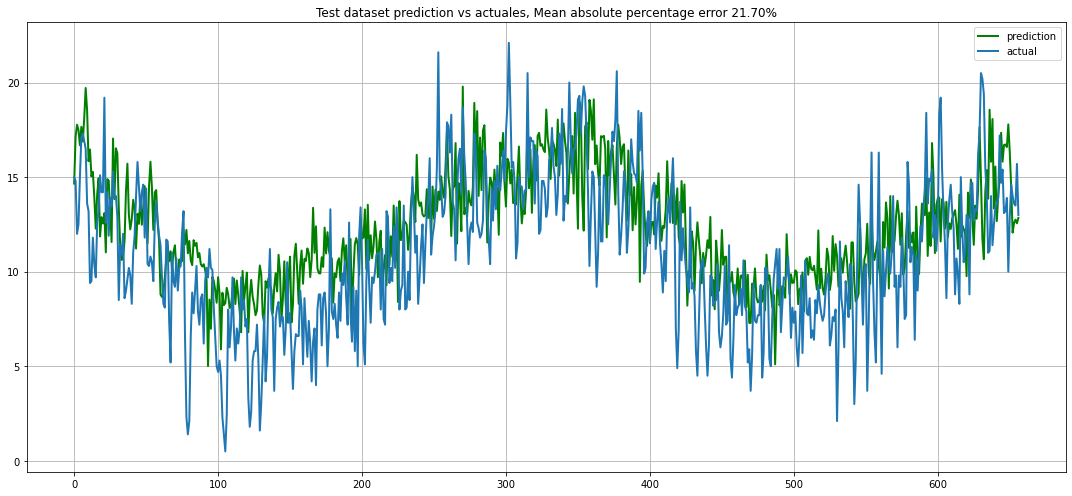

In [184]:
plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test, 
                 y_test = y_test,
                # plot_intervals=True
                )

In [185]:
# MAPE AND R2
y_pred_xgb = xgb.predict(X_test)

print('Train MAPE: ' + str(mean_absolute_percentage_error(y_train+0.01, xgb.predict(X_train+0.01))))
print('Test MAPE: ' + str(mean_absolute_percentage_error(y_test, y_pred_xgb)))

print('Train R2: ' + str(r2_score(y_train+0.01, xgb.predict(X_train+0.01))))
print('Test R2: ' + str(r2_score(y_test+0.01, y_pred_xgb+0.01)))

Train MAPE: 10.473066610162418
Test MAPE: 36.479334745381365
Train R2: 0.9653426726711691
Test R2: 0.31093724564967873


This model would need hyperparameter tuning and checking the variable importance